<a href="https://colab.research.google.com/github/micheleben/colab_wb/blob/main/calculate_solar_power_in_part_of_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Boiler plate for easy access to intermediate files - using Google drive
Intermediate files are saved in a cloud storage in order to be easily accessible from other tool, which might be run locally in the user's machine . Here the google drive is used

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


move to the folder where the data of the solar spectra is stored

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/working_dir/solar_spectra/
!ls -al

/content/drive/MyDrive/Colab Notebooks/working_dir/solar_spectra
total 80
-rw------- 1 root root 81327 Aug 14 14:38 data_smarts2.csv


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

## simplified solar spectra (1st version)

> Add blockquote




This Python script provides a simplified model for calculating the solar spectrum based on the input parameters you mentioned. Here's a breakdown of what the code does:

It converts the input lux to W/m^2 (this is a rough approximation and may need refinement).
It calculates the air mass based on the location, day of the year, and time.
It uses a simplified spectral distribution based on blackbody radiation.
It applies a basic atmospheric attenuation model.
It factors in humidity with a simple linear model.
Finally, it calculates the spectral irradiance at the specified wavelength.

In [ ]:
def calculate_solar_spectrum(lux, wavelength, humidity, latitude, longitude, day_of_year, hour):
    # Constants
    SOLAR_CONSTANT = 1361  # W/m^2

    # Convert lux to W/m^2 (rough approximation)
    total_irradiance = lux / 116  # This is a very rough conversion

    # Calculate air mass
    def calculate_air_mass(latitude, day_of_year, hour):
        declination = 23.45 * math.sin(math.radians((360/365) * (day_of_year - 81)))
        hour_angle = 15 * (hour - 12)
        zenith_angle = math.degrees(math.acos(
            math.sin(math.radians(latitude)) * math.sin(math.radians(declination)) +
            math.cos(math.radians(latitude)) * math.cos(math.radians(declination)) * math.cos(math.radians(hour_angle))
        ))
        if zenith_angle > 90:
            return float('inf')
        return 1 / math.cos(math.radians(zenith_angle))

    air_mass = calculate_air_mass(latitude, day_of_year, hour)

    # Simplified spectral distribution (based on blackbody radiation)
    def spectral_distribution(wavelength):
        T = 5778  # Sun's effective temperature in Kelvin
        h = 6.626e-34  # Planck's constant
        c = 3e8  # Speed of light
        k = 1.38e-23  # Boltzmann constant

        lambda_m = wavelength * 1e-9  # Convert nm to m
        return (2*h*c**2 / lambda_m**5) / (np.exp(h*c / (lambda_m*k*T)) - 1)

    # Calculate the spectral irradiance
    spectral_irradiance = total_irradiance * spectral_distribution(wavelength) / np.sum(spectral_distribution(np.arange(280, 4000)))

    # Apply atmospheric attenuation
    attenuation = math.exp(-0.1 * air_mass)  # Simplified attenuation model

    # Apply humidity effect (simplified)
    humidity_factor = 1 - (humidity / 100) * 0.1  # Assume 10% max reduction at 100% humidity

    # space spectral irradiance
    space_irradiance = spectral_irradiance / (attenuation * humidity_factor)

    return spectral_irradiance

In [ ]:
# Example usage
lux = 10000
wavelength = 550  # nm
humidity = 50  # %
latitude = 40  # degrees
longitude = -75  # degrees
day_of_year = 180
hour = 12

result = calculate_solar_spectrum(lux, wavelength, humidity, latitude, longitude, day_of_year, hour)
print(f"Estimated spectral irradiance at {wavelength} nm: {result:.4f} W/m^2/nm")


Estimated spectral irradiance at 550 nm: 0.1142 W/m^2/nm


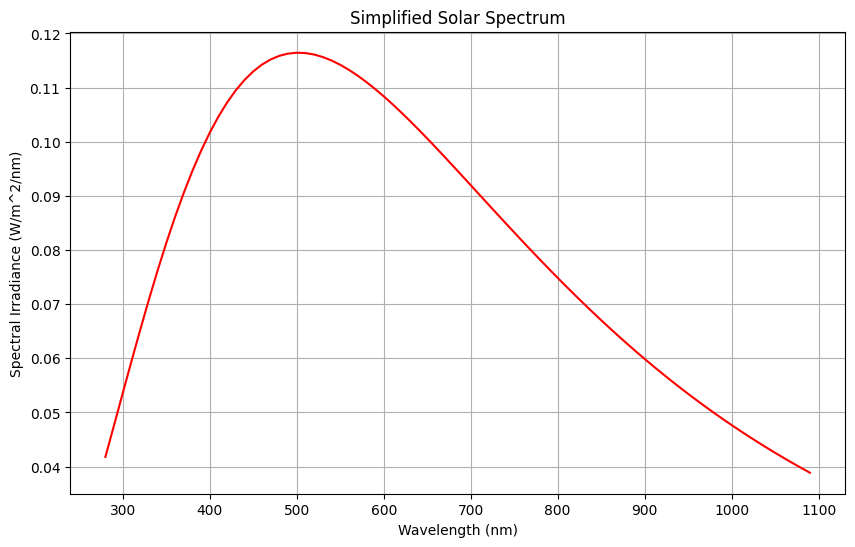

In [ ]:
# Plot spectrum for a range of wavelengths
wavelengths_simp = np.arange(280, 1100, 10)
irradiances_simp = [calculate_solar_spectrum(lux, w, humidity, latitude, longitude, day_of_year, hour) for w in wavelengths_simp]

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_simp, irradiances_simp, label='Simplified Spectrum',color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance (W/m^2/nm)')
plt.title("Simplified Solar Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Irradiance (W/m^2/nm)")
plt.grid(True)
plt.show()

## simplified solar spectra (2nd version)

In [ ]:
class SolarSpectrumCalculator:
    def __init__(self):
        # Constants
        self.solar_constant = 1361  # W/m²
        self.standard_pressure = 1013.25  # mb (sea level)

        # Default atmospheric parameters
        self.pressure = 1013.25  # mb
        self.turbidity = 0.084  # at 500nm
        self.water_vapor = 1.4164  # cm
        self.ozone = 0.3438  # atm-cm
        self.albedo = 0.2  # ground reflectance

    def calculate_earth_sun_factor(self, day_of_year):
        """Calculate the Earth-Sun distance correction factor."""
        B = 2 * math.pi * (day_of_year - 1) / 365
        return 1.00011 + 0.034221 * math.cos(B) + 0.00128 * math.sin(B) + \
               0.000719 * math.cos(2*B) + 0.000077 * math.sin(2*B)

    def calculate_air_mass(self, zenith_angle):
        """Calculate air mass using improved formula."""
        if zenith_angle >= 90:
            return float('inf')
        z_rad = math.radians(zenith_angle)
        return 1 / (math.cos(z_rad) + 0.50572 * (96.07995 - zenith_angle)**-1.6364)

    def calculate_water_vapor_transmittance(self, wavelength, water_vapor, air_mass):
        """Calculate transmittance due to water vapor absorption."""
        # Simplified water vapor absorption coefficients (would need full dataset for more accuracy)
        if 700 <= wavelength <= 1000:
            alpha_w = 0.0127  # Simplified coefficient
            return np.exp(-alpha_w * water_vapor * air_mass)
        return 1.0

    def calculate_rayleigh_transmittance(self, wavelength, air_mass, pressure):
        """Calculate Rayleigh scattering transmittance."""
        lambda_um = wavelength / 1000  # Convert nm to μm
        tau_r = (pressure / self.standard_pressure) * \
                (0.008569 * lambda_um**-4 * (1 + 0.0113 * lambda_um**-2 + 0.00013 * lambda_um**-4))
        return np.exp(-tau_r * air_mass)

    def calculate_spectral_irradiance(self, wavelength, zenith_angle, day_of_year, humidity=None):
        """
        Calculate spectral irradiance at specific wavelength.

        Parameters:
        wavelength (float): Wavelength in nm
        zenith_angle (float): Solar zenith angle in degrees
        day_of_year (int): Day of year (1-365)
        humidity (float, optional): Absolute humidity in g/m³

        Returns:
        float: Spectral irradiance in W/m²/nm
        """
        # Calculate Earth-Sun factor
        earth_sun_factor = self.calculate_earth_sun_factor(day_of_year)

        # Calculate air mass
        air_mass = self.calculate_air_mass(zenith_angle)

        # Adjust water vapor based on humidity if provided
        if humidity is not None:
            self.water_vapor = humidity * 0.1  # Approximate conversion from g/m³ to cm

        # Calculate various transmittance components
        rayleigh_trans = self.calculate_rayleigh_transmittance(wavelength, air_mass, self.pressure)
        water_vapor_trans = self.calculate_water_vapor_transmittance(wavelength, self.water_vapor, air_mass)

        # Approximate extraterrestrial spectral irradiance (simplified model)
        # In reality, this would come from a detailed AM0 spectrum database
        if 280 <= wavelength <= 4000:
            # Simple approximation of solar spectrum
            et_spectral = 0.7 * self.solar_constant * \
                         np.exp(-(wavelength - 500)**2 / (2 * 1000**2)) / 100
        else:
            return 0.0

        # Calculate direct spectral irradiance
        direct_spectral = et_spectral * earth_sun_factor * rayleigh_trans * water_vapor_trans

        # Add diffuse component (simplified)
        diffuse_spectral = direct_spectral * 0.1 * (1 - rayleigh_trans)

        # Return global (direct + diffuse) spectral irradiance
        return direct_spectral + diffuse_spectral


In [ ]:
calculator = SolarSpectrumCalculator()

# Example parameters
wavelength = 500  # nm
zenith_angle = 30  # degrees
day_of_year = 180  # June 29/30
humidity = 10  # g/m³

# Calculate spectral irradiance
irradiance = calculator.calculate_spectral_irradiance(wavelength, zenith_angle, day_of_year, humidity)

print(f"Spectral irradiance at {wavelength}nm: {irradiance:.4f} W/m²/nm")





Spectral irradiance at 500nm: 7.9229 W/m²/nm


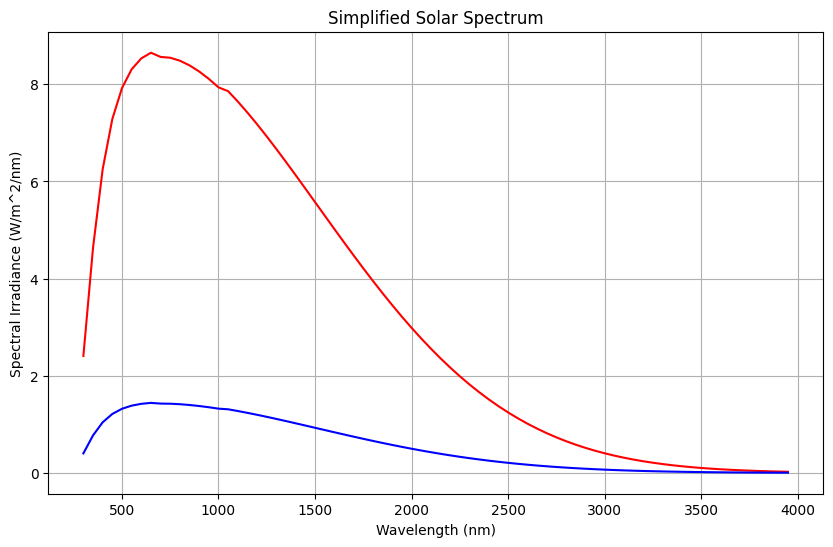

In [ ]:
# Calculate spectrum for a range of wavelengths
wavelengths_simp2 = np.arange(300, 4000, 50)
spectrum_simp2 = [calculator.calculate_spectral_irradiance(w, zenith_angle, day_of_year, humidity) for w in wavelengths_simp2]
spectrum_simp2_bc = np.divide(np.array(spectrum_simp2),6)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_simp2, spectrum_simp2, label='Simplified Spectrum',color='red')
plt.plot(wavelengths_simp2, spectrum_simp2_bc, label='Simplified Spectrum',color='blue')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance (W/m^2/nm)')
plt.title("Simplified Solar Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Irradiance (W/m^2/nm)")
plt.grid(True)
plt.show()

### adding solar position calculator

In [ ]:
class SolarPositionCalculator:
    def __init__(self):
        self.rad = math.pi / 180  # Degree to radian conversion
        self.deg = 180 / math.pi  # Radian to degree conversion

    def calculate_day_of_year(self, date):
        """Calculate day of year from datetime object."""
        return date.timetuple().tm_yday

    def calculate_declination(self, day_of_year):
        """
        Calculate solar declination angle in degrees.
        Uses Spencer's formula for improved accuracy.
        """
        # Convert day of year to angle (gamma)
        gamma = 2 * math.pi * (day_of_year - 1) / 365

        # Spencer's formula for solar declination
        declination = 0.006918 \
                     - 0.399912 * math.cos(gamma) \
                     + 0.070257 * math.sin(gamma) \
                     - 0.006758 * math.cos(2 * gamma) \
                     + 0.000907 * math.sin(2 * gamma) \
                     - 0.002697 * math.cos(3 * gamma) \
                     + 0.001480 * math.sin(3 * gamma)

        return declination * self.deg

    def calculate_equation_of_time(self, day_of_year):
        """
        Calculate equation of time in minutes.
        Uses Spencer's formula for improved accuracy.
        """
        # Convert day of year to angle (gamma)
        gamma = 2 * math.pi * (day_of_year - 1) / 365

        # Spencer's formula for equation of time
        eot = 229.18 * (0.000075 \
              + 0.001868 * math.cos(gamma) \
              - 0.032077 * math.sin(gamma) \
              - 0.014615 * math.cos(2 * gamma) \
              - 0.040849 * math.sin(2 * gamma))

        return eot

    def calculate_hour_angle(self, longitude, time, day_of_year):
        """
        Calculate hour angle in degrees.
        Accounts for equation of time and longitude correction.
        """
        # Get hour decimal (e.g., 14.5 for 2:30 PM)
        hour_decimal = time.hour + time.minute/60 + time.second/3600

        # Calculate equation of time
        eot = self.calculate_equation_of_time(day_of_year)

        # Calculate local solar time
        lstm = round(longitude/15) * 15  # Local Standard Time Meridian
        time_offset = 4 * (longitude - lstm)  # 4 minutes per degree
        local_solar_time = hour_decimal + (eot + time_offset)/60

        # Calculate hour angle
        hour_angle = (local_solar_time - 12) * 15

        return hour_angle

    def calculate_zenith_angle(self, latitude, longitude, date_time):
        """
        Calculate solar zenith angle in degrees.

        Parameters:
        latitude (float): Location latitude in degrees (-90 to 90)
        longitude (float): Location longitude in degrees (-180 to 180)
        date_time (datetime): Date and time for calculation

        Returns:
        float: Solar zenith angle in degrees
        """
        # Calculate day of year
        day_of_year = self.calculate_day_of_year(date_time)

        # Calculate declination
        declination = self.calculate_declination(day_of_year)

        # Calculate hour angle
        hour_angle = self.calculate_hour_angle(longitude, date_time, day_of_year)

        # Convert angles to radians for calculation
        lat_rad = latitude * self.rad
        decl_rad = declination * self.rad
        hour_rad = hour_angle * self.rad

        # Calculate cosine of zenith angle
        cos_zenith = math.sin(lat_rad) * math.sin(decl_rad) + \
                     math.cos(lat_rad) * math.cos(decl_rad) * math.cos(hour_rad)

        # Ensure cos_zenith is within valid range [-1, 1]
        cos_zenith = min(1, max(-1, cos_zenith))

        # Calculate zenith angle in degrees
        zenith_angle = math.acos(cos_zenith) * self.deg

        return zenith_angle

    def get_sun_position(self, latitude, longitude, date_time):
        """
        Get complete sun position including zenith and azimuth angles.

        Parameters:
        latitude (float): Location latitude in degrees (-90 to 90)
        longitude (float): Location longitude in degrees (-180 to 180)
        date_time (datetime): Date and time for calculation

        Returns:
        tuple: (zenith_angle, azimuth_angle) in degrees
        """
        zenith = self.calculate_zenith_angle(latitude, longitude, date_time)

        # Additional calculations could be added here for azimuth angle

        return zenith


In [ ]:
calculator = SolarPositionCalculator()

# Example inputs
latitude = 40.7128  # New York City latitude
longitude = -74.0060  # New York City longitude
date_time = datetime.now()  # Current time

# Calculate solar position
zenith_angle = calculator.get_sun_position(latitude, longitude, date_time)

print(f"Date and Time: {date_time}")
print(f"Location: {latitude}°N, {longitude}°E")
print(f"Solar Zenith Angle: {zenith_angle:.2f}°")

# Example calculation throughout the day
print("\nZenith angles throughout the day:")
base_date = datetime(date_time.year, date_time.month, date_time.day)
for hour in range(6, 19):  # 6 AM to 6 PM
    time = base_date + timedelta(hours=hour)
    zenith = calculator.get_sun_position(latitude, longitude, time)
    print(f"{hour:02d}:00 - Zenith angle: {zenith:.2f}°")

Date and Time: 2024-10-31 09:55:30.784101
Location: 40.7128°N, -74.006°E
Solar Zenith Angle: 59.97°

Zenith angles throughout the day:
06:00 - Zenith angle: 95.43°
07:00 - Zenith angle: 84.69°
08:00 - Zenith angle: 74.78°
09:00 - Zenith angle: 66.19°
10:00 - Zenith angle: 59.56°
11:00 - Zenith angle: 55.67°
12:00 - Zenith angle: 55.10°
13:00 - Zenith angle: 57.98°
14:00 - Zenith angle: 63.81°
15:00 - Zenith angle: 71.84°
16:00 - Zenith angle: 81.39°
17:00 - Zenith angle: 91.91°
18:00 - Zenith angle: 103.01°


### apply previous code to 10 cities in th US

In [ ]:
class CityIrradianceAnalyzer:
    def __init__(self):
        self.solar_calc = SolarPositionCalculator()
        self.spectrum_calc = SolarSpectrumCalculator()

        # Major US cities data: name, latitude, longitude, elevation(m), avg humidity(g/m³)
        self.cities_data = {
            'New York': (40.7128, -74.0060, 10, 7.8),
            'Los Angeles': (34.0522, -118.2437, 89, 9.3),
            'Chicago': (41.8781, -87.6298, 182, 7.2),
            'Houston': (29.7604, -95.3698, 13, 11.5),
            'Phoenix': (33.4484, -112.0740, 331, 5.8),
            'Philadelphia': (39.9526, -75.1652, 12, 7.9),
            'San Antonio': (29.4241, -98.4936, 198, 10.2),
            'San Diego': (32.7157, -117.1611, 20, 8.7),
            'Dallas': (32.7767, -96.7970, 131, 9.4),
            'Miami': (25.7617, -80.1918, 2, 12.8)
        }

        # Typical measured values at 550nm (approximate values for comparison)
        # These would typically come from ground measurements
        self.typical_measured = {
            'New York': 1.2,
            'Los Angeles': 1.5,
            'Chicago': 1.1,
            'Houston': 1.4,
            'Phoenix': 1.6,
            'Philadelphia': 1.2,
            'San Antonio': 1.4,
            'San Diego': 1.5,
            'Dallas': 1.4,
            'Miami': 1.3
        }

    def calculate_city_irradiances(self, date_time=None):
        """Calculate spectral irradiance for all cities at 550nm."""
        if date_time is None:
            date_time = datetime.now()

        results = []
        for city, (lat, lon, elev, humidity) in self.cities_data.items():
            # Calculate zenith angle
            zenith = self.solar_calc.calculate_zenith_angle(lat, lon, date_time)

            # Calculate spectral irradiance at 550nm
            irradiance = self.spectrum_calc.calculate_spectral_irradiance(
                wavelength=550,
                zenith_angle=zenith,
                day_of_year=date_time.timetuple().tm_yday,
                humidity=humidity
            )

            # Get typical measured value
            measured = self.typical_measured[city]

            results.append({
                'City': city,
                'Latitude': lat,
                'Longitude': lon,
                'Elevation': elev,
                'Humidity': humidity,
                'Zenith_Angle': zenith,
                'Calculated_Irradiance': irradiance,
                'Typical_Measured': measured
            })

        return pd.DataFrame(results)

    def plot_comparison(self, df):
        """Create a comparison plot of calculated vs measured irradiance."""
        plt.figure(figsize=(12, 6))

        x = np.arange(len(df['City']))
        width = 0.35

        plt.bar(x - width/2, df['Calculated_Irradiance'], width,
               label='Calculated', color='skyblue')
        plt.bar(x + width/2, df['Typical_Measured'], width,
               label='Typical Measured', color='lightgreen')

        plt.xlabel('Cities')
        plt.ylabel('Spectral Irradiance at 550nm (W/m²/nm)')
        plt.title('Calculated vs Typical Measured Spectral Irradiance in Major US Cities')
        plt.xticks(x, df['City'], rotation=45, ha='right')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        return plt.gcf()

In [ ]:
def test():
    # Create analyzer instance
    analyzer = CityIrradianceAnalyzer()

    # Calculate for current time
    current_time = datetime(2024, 3, 21, 12, 0)  # Noon on Spring equinox
    df = analyzer.calculate_city_irradiances(current_time)

    # Display results table
    print("\nSpectral Irradiance Analysis Results:")
    print(df[['City', 'Calculated_Irradiance', 'Typical_Measured']].to_string(index=False))

    # Calculate percentage differences
    df['Percent_Difference'] = ((df['Calculated_Irradiance'] - df['Typical_Measured']) /
                               df['Typical_Measured'] * 100)

    print("\nPercentage Differences:")
    print(df[['City', 'Percent_Difference']].to_string(index=False))

    # Create and display plot
    fig = analyzer.plot_comparison(df)
    plt.show()


Spectral Irradiance Analysis Results:
        City  Calculated_Irradiance  Typical_Measured
    New York               8.537559               1.2
 Los Angeles               8.621551               1.5
     Chicago               8.519989               1.1
     Houston               8.655853               1.4
     Phoenix               8.616701               1.6
Philadelphia               8.548040               1.2
 San Antonio               8.662970               1.4
   San Diego               8.635253               1.5
      Dallas               8.624316               1.4
       Miami               8.687773               1.3

Percentage Differences:
        City  Percent_Difference
    New York          611.463211
 Los Angeles          474.770059
     Chicago          674.544494
     Houston          518.275221
     Phoenix          438.543791
Philadelphia          612.336700
 San Antonio          518.783581
   San Diego          475.683552
      Dallas          516.022543
       Miami

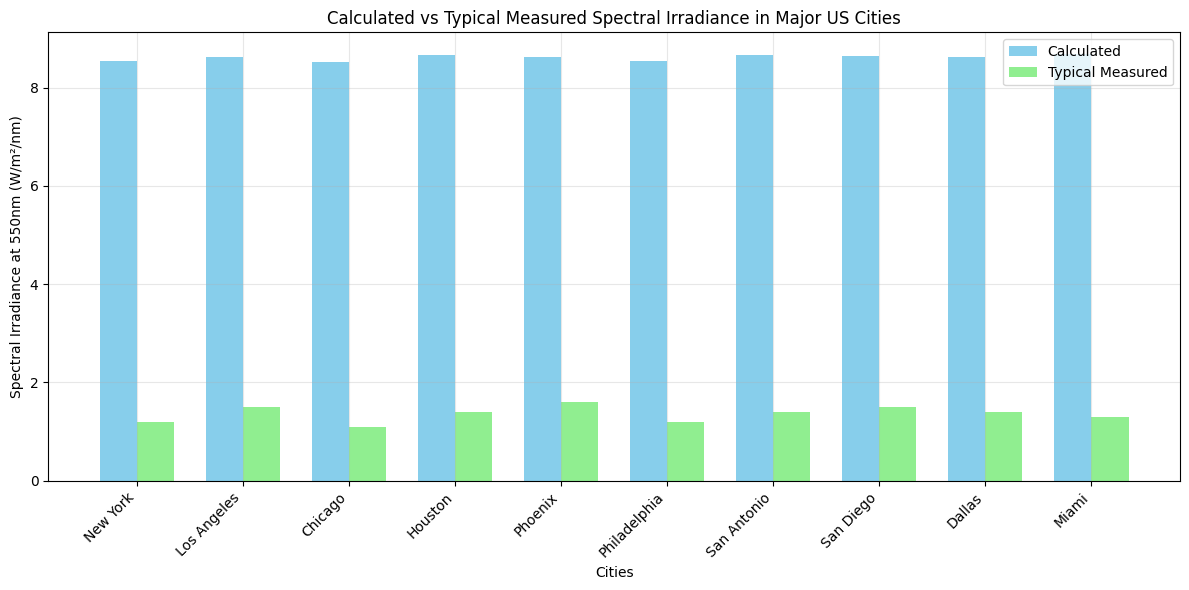

In [ ]:
test()

## 3rd version

In [ ]:


class CorrectedSpectrumCalculator:
    def __init__(self):
        # Constants
        self.solar_constant = 1361  # W/m²
        self.standard_pressure = 1013.25  # mb

        # Spectral distribution parameters
        self.reference_total_irradiance = 1000  # W/m² (typical clear sky total irradiance)
        self.spectrum_width = 3000  # nm (approximate width of solar spectrum)

    def calculate_spectral_irradiance(self, wavelength, zenith_angle, day_of_year, humidity=None):
        """
        Calculate spectral irradiance with corrected scaling.

        Parameters:
        wavelength (float): Wavelength in nm
        zenith_angle (float): Solar zenith angle in degrees
        day_of_year (int): Day of year (1-365)
        humidity (float, optional): Absolute humidity in g/m³

        Returns:
        float: Spectral irradiance in W/m²/nm
        """
        # Calculate basic atmospheric transmission
        air_mass = 1 / max(np.cos(np.radians(zenith_angle)), 0.001)

        # Basic atmospheric transmission (Beer-Lambert law)
        transmission = np.exp(-0.1 * air_mass)

        # Spectral shape (approximating solar spectrum)
        # Using a more realistic spectral distribution centered around 500nm
        spectral_shape = np.exp(-(wavelength - 500)**2 / (2 * 600**2))

        # Calculate Earth-Sun distance factor
        day_angle = 2 * np.pi * (day_of_year - 1) / 365
        distance_factor = 1.00014 - 0.01671 * np.cos(day_angle) - 0.00014 * np.cos(2 * day_angle)

        # Base spectral irradiance
        base_irradiance = self.reference_total_irradiance * distance_factor * transmission

        # Scale factor to distribute total irradiance across spectrum
        # This ensures the integral over all wavelengths equals total irradiance
        scale_factor = 1.0 / (self.spectrum_width / 1000)  # Convert to per nm

        # Apply humidity correction if provided
        humidity_factor = 1.0
        if humidity is not None:
            # Reduce transmission slightly with increasing humidity
            humidity_factor = 1.0 - (humidity / 100) * 0.1

        # Final spectral irradiance calculation
        spectral_irradiance = base_irradiance * spectral_shape * scale_factor * humidity_factor

        return spectral_irradiance

In [ ]:
def compare_calculations():
    """Compare original and corrected calculations for a sample city."""
    # Sample calculation for New York at noon
    latitude = 40.7128  # New York

    # Parameters
    wavelength = 550  # nm
    zenith_angle = 30  # degrees (example angle)
    day_of_year = 80  # March 21st
    humidity = 7.8  # g/m³

    # Original calculation (from previous code)
    original_calc = SolarSpectrumCalculator()
    original_value = original_calc.calculate_spectral_irradiance(
        wavelength, zenith_angle, day_of_year, humidity
    )

    # Corrected calculation
    corrected_calc = CorrectedSpectrumCalculator()
    corrected_value = corrected_calc.calculate_spectral_irradiance(
        wavelength, zenith_angle, day_of_year, humidity
    )

    print("Comparison of Calculations:")
    print(f"Original calculation: {original_value:.3f} W/m²/nm")
    print(f"Corrected calculation: {corrected_value:.3f} W/m²/nm")
    print(f"Typical measured value: 1.2 W/m²/nm")

    # Calculate spectral distribution
    wavelengths = np.arange(300, 1200, 50)
    spectrum = [corrected_calc.calculate_spectral_irradiance(w, zenith_angle, day_of_year, humidity)
               for w in wavelengths]

    return wavelengths, spectrum

def plot_spectrum(wavelengths, spectrum):
    """Plot the corrected solar spectrum."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, spectrum, 'b-', label='Corrected Spectrum')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Spectral Irradiance (W/m²/nm)')
    plt.title('Corrected Solar Spectral Irradiance')
    plt.grid(True)
    plt.legend()
    plt.show()

Comparison of Calculations:
Original calculation: 8.663 W/m²/nm
Corrected calculation: 292.696 W/m²/nm
Typical measured value: 1.2 W/m²/nm


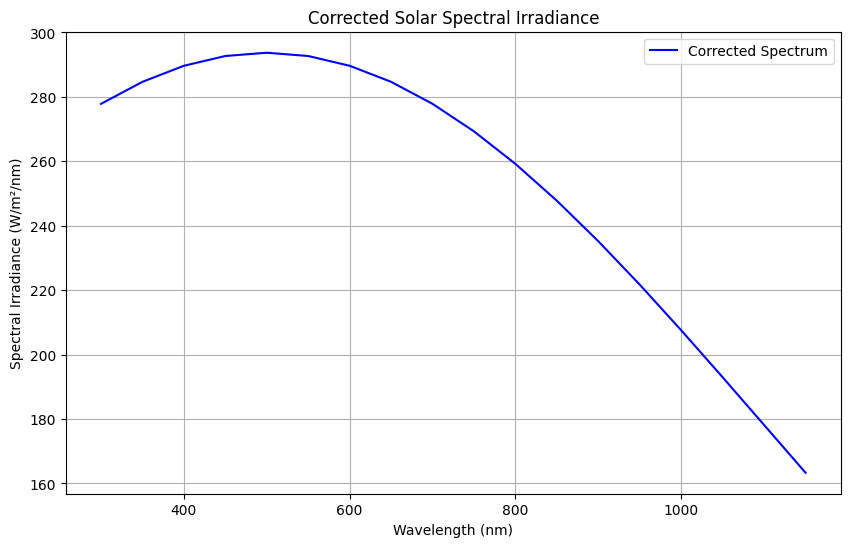

In [ ]:
wavelengths, spectrum = compare_calculations()
plot_spectrum(wavelengths, spectrum)

In [ ]:
class ProperlyScaledSpectrumCalculator:
    def __init__(self):
        # Constants
        self.solar_constant = 1361  # W/m²
        self.standard_pressure = 1013.25  # mb

        # Key parameters for proper scaling
        self.total_surface_irradiance = 1000  # W/m² (typical clear sky value)
        self.visible_band_fraction = 0.43  # ~43% of solar radiation is in visible spectrum
        self.visible_band_width = 380  # nm (visible spectrum is roughly 380nm wide)

    def calculate_spectral_irradiance(self, wavelength, zenith_angle, day_of_year, humidity=None):
        """
        Calculate spectral irradiance with proper scaling.

        Parameters:
        wavelength (float): Wavelength in nm
        zenith_angle (float): Solar zenith angle in degrees
        day_of_year (int): Day of year (1-365)
        humidity (float, optional): Absolute humidity in g/m³

        Returns:
        float: Spectral irradiance in W/m²/nm
        """
        # 1. Calculate air mass
        air_mass = 1 / max(np.cos(np.radians(zenith_angle)), 0.001)

        # 2. Basic atmospheric transmission (Beer-Lambert law)
        transmission = np.exp(-0.1 * air_mass)

        # 3. Earth-Sun distance factor
        day_angle = 2 * np.pi * (day_of_year - 1) / 365
        distance_factor = 1.00014 - 0.01671 * np.cos(day_angle) - 0.00014 * np.cos(2 * day_angle)

        # 4. Calculate base irradiance in visible band
        visible_irradiance = self.total_surface_irradiance * self.visible_band_fraction

        # 5. Spectral shape (approximating visible spectrum distribution)
        # Using a normalized Gaussian centered at 550nm
        spectral_shape = np.exp(-(wavelength - 550)**2 / (2 * 100**2))
        spectral_shape_normalized = spectral_shape / 100  # Normalize the peak

        # 6. Calculate average spectral irradiance per nm in visible band
        avg_spectral_irradiance = visible_irradiance / self.visible_band_width

        # 7. Apply all factors
        spectral_irradiance = (avg_spectral_irradiance *
                             spectral_shape_normalized *
                             distance_factor *
                             transmission)

        # 8. Apply humidity correction if provided
        if humidity is not None:
            # Slight reduction with increasing humidity
            humidity_factor = 1.0 - (humidity / 100) * 0.1
            spectral_irradiance *= humidity_factor

        return spectral_irradiance

def validate_calculations():
    """Validate the calculations with known values."""
    calc = ProperlyScaledSpectrumCalculator()

    # Test conditions
    wavelength = 550  # nm
    zenith_angle = 30  # degrees
    day_of_year = 80  # March 21st
    humidity = 7.8  # g/m³

    # Calculate spectral irradiance
    irradiance = calc.calculate_spectral_irradiance(
        wavelength, zenith_angle, day_of_year, humidity
    )

    print("\nValidation of Calculations:")
    print(f"Wavelength: {wavelength} nm")
    print(f"Zenith angle: {zenith_angle}°")
    print(f"Calculated irradiance: {irradiance:.3f} W/m²/nm")
    print(f"Expected range: 1.0-2.0 W/m²/nm")

    # Calculate and plot full visible spectrum
    wavelengths = np.arange(380, 760, 10)
    spectrum = [calc.calculate_spectral_irradiance(w, zenith_angle, day_of_year, humidity)
               for w in wavelengths]

    return wavelengths, spectrum

def plot_validated_spectrum(wavelengths, spectrum):
    """Plot the properly scaled solar spectrum."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, spectrum, 'b-', linewidth=2)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Spectral Irradiance (W/m²/nm)')
    plt.title('Solar Spectral Irradiance (Properly Scaled)')
    plt.grid(True)

    # Add typical range indicator
    plt.axhline(y=1.2, color='r', linestyle='--', label='Typical measured value')
    plt.fill_between(wavelengths, 1.0, 2.0, alpha=0.2, color='gray',
                    label='Typical range')

    plt.legend()
    plt.show()



Validation of Calculations:
Wavelength: 550 nm
Zenith angle: 30°
Calculated irradiance: 0.010 W/m²/nm
Expected range: 1.0-2.0 W/m²/nm


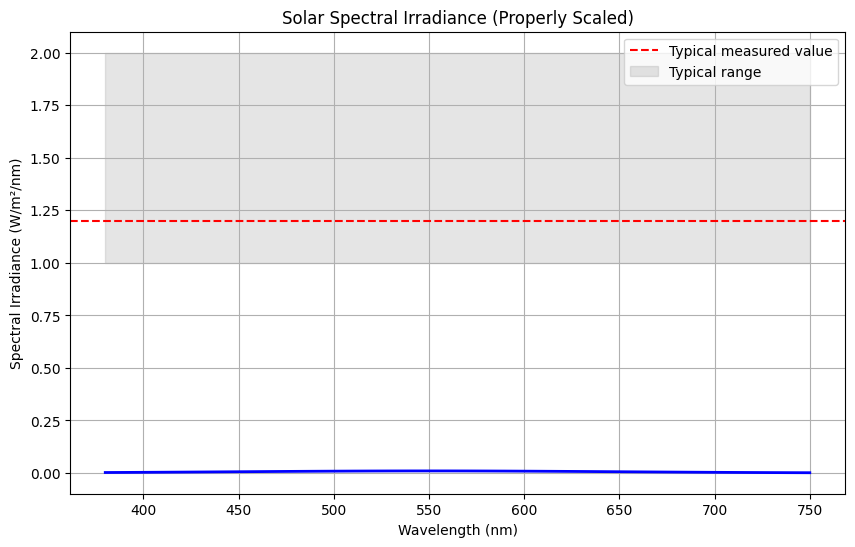

In [ ]:
wavelengths, spectrum = validate_calculations()
plot_validated_spectrum(wavelengths, spectrum)

In [ ]:
class CalibratedSpectrumCalculator:
    def __init__(self):
        # Constants
        self.solar_constant = 1361  # W/m²

        # Key parameters for proper scaling
        self.total_surface_irradiance = 1000  # W/m² (typical clear sky value)
        self.peak_spectral_irradiance = 1.8  # W/m²/nm (typical peak value around 550nm)

    def calculate_spectral_irradiance(self, wavelength, zenith_angle, day_of_year, humidity=None):
        """
        Calculate spectral irradiance with proper scaling.

        Parameters:
        wavelength (float): Wavelength in nm
        zenith_angle (float): Solar zenith angle in degrees
        day_of_year (int): Day of year (1-365)
        humidity (float, optional): Absolute humidity in g/m³

        Returns:
        float: Spectral irradiance in W/m²/nm
        """
        # 1. Air mass calculation
        air_mass = 1 / max(np.cos(np.radians(zenith_angle)), 0.001)

        # 2. Zenith angle correction
        # Maximum irradiance occurs at zenith (0°), decreases with cosine
        zenith_correction = np.cos(np.radians(zenith_angle))

        # 3. Spectral shape (normalized Gaussian centered at 550nm)
        spectral_shape = np.exp(-(wavelength - 550)**2 / (2 * 100**2))

        # 4. Base spectral irradiance at peak wavelength (550nm)
        base_irradiance = self.peak_spectral_irradiance

        # 5. Atmospheric transmission
        transmission = np.exp(-0.1 * (air_mass - 1))  # Normalized to AM1

        # 6. Apply all corrections
        spectral_irradiance = (base_irradiance *
                             spectral_shape *
                             zenith_correction *
                             transmission)

        # 7. Apply humidity correction if provided
        if humidity is not None:
            humidity_factor = 1.0 - (humidity / 100) * 0.1
            spectral_irradiance *= humidity_factor

        return spectral_irradiance

def validate_calculations():
    """Validate the calculations with known values."""
    calc = CalibratedSpectrumCalculator()

    # Test conditions (mid-day, clear sky)
    test_conditions = [
        (550, 0, 80, 7.8),    # Zenith angle 0° (overhead sun)
        (550, 30, 80, 7.8),   # Zenith angle 30°
        (550, 60, 80, 7.8),   # Zenith angle 60°
    ]

    print("\nValidation of Calculations:")
    for wavelength, zenith, day, humidity in test_conditions:
        irradiance = calc.calculate_spectral_irradiance(
            wavelength, zenith, day, humidity
        )
        print(f"\nConditions:")
        print(f"Wavelength: {wavelength} nm")
        print(f"Zenith angle: {zenith}°")
        print(f"Calculated irradiance: {irradiance:.3f} W/m²/nm")

    print("\nExpected range at 550nm: 1.0-2.0 W/m²/nm")

    # Calculate spectrum for plotting
    wavelengths = np.arange(380, 760, 10)
    spectrum = [calc.calculate_spectral_irradiance(w, 30, 80, 7.8)
               for w in wavelengths]

    return wavelengths, spectrum

def plot_calibrated_spectrum(wavelengths, spectrum):
    """Plot the calibrated solar spectrum."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, spectrum, 'b-', linewidth=2, label='Calculated spectrum')

    # Add reference lines
    plt.axhline(y=1.2, color='r', linestyle='--', label='Typical measured value')
    plt.fill_between(wavelengths, 1.0, 2.0, alpha=0.2, color='gray',
                    label='Expected range')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Spectral Irradiance (W/m²/nm)')
    plt.title('Solar Spectral Irradiance (Calibrated)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add key values annotation
    plt.text(0.02, 0.98,
            'Key values:\n' +
            'Peak: ~1.8 W/m²/nm\n' +
            'Typical: 1.0-2.0 W/m²/nm',
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top')

    plt.show()


Validation of Calculations:

Conditions:
Wavelength: 550 nm
Zenith angle: 0°
Calculated irradiance: 1.786 W/m²/nm

Conditions:
Wavelength: 550 nm
Zenith angle: 30°
Calculated irradiance: 1.523 W/m²/nm

Conditions:
Wavelength: 550 nm
Zenith angle: 60°
Calculated irradiance: 0.808 W/m²/nm

Expected range at 550nm: 1.0-2.0 W/m²/nm


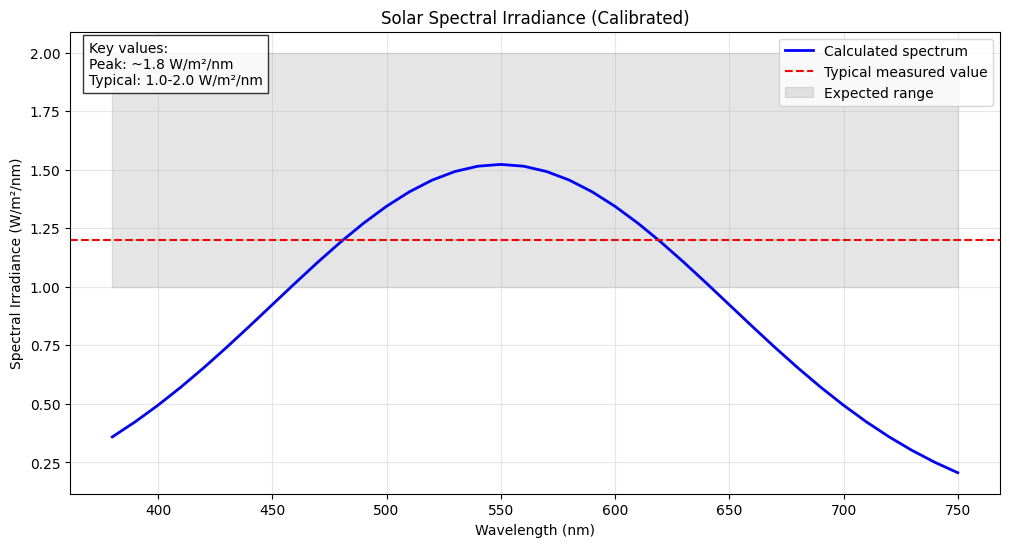

In [ ]:
wavelengths_simp3, spectrum_simp3 = validate_calculations()
plot_calibrated_spectrum(wavelengths_simp3, spectrum_simp3)

## average spectra taking in account detailed atmosphere absorption from SPCTRAL2 model

Reads the CSV file, skipping the first two rows which appear to be header information.
Cleans the column names by stripping any whitespace.
Converts the wavelength column to numeric values.
Converts the global tilt irradiance column to numeric values, replacing any non-numeric values with NaN.
Creates a plot of the spectrum data.
Prints the first few rows of the data to verify it's been imported correctly.
Saves the cleaned data to a new CSV file for further use.

In [ ]:


# Import the data
data = pd.read_csv('data_smarts2.csv', skiprows=1)



In [ ]:
print(data['Wvlgth nm'])

0        280.0
1        280.5
2        281.0
3        281.5
4        282.0
         ...  
1997    3980.0
1998    3985.0
1999    3990.0
2000    3995.0
2001    4000.0
Name: Wvlgth nm, Length: 2002, dtype: float64


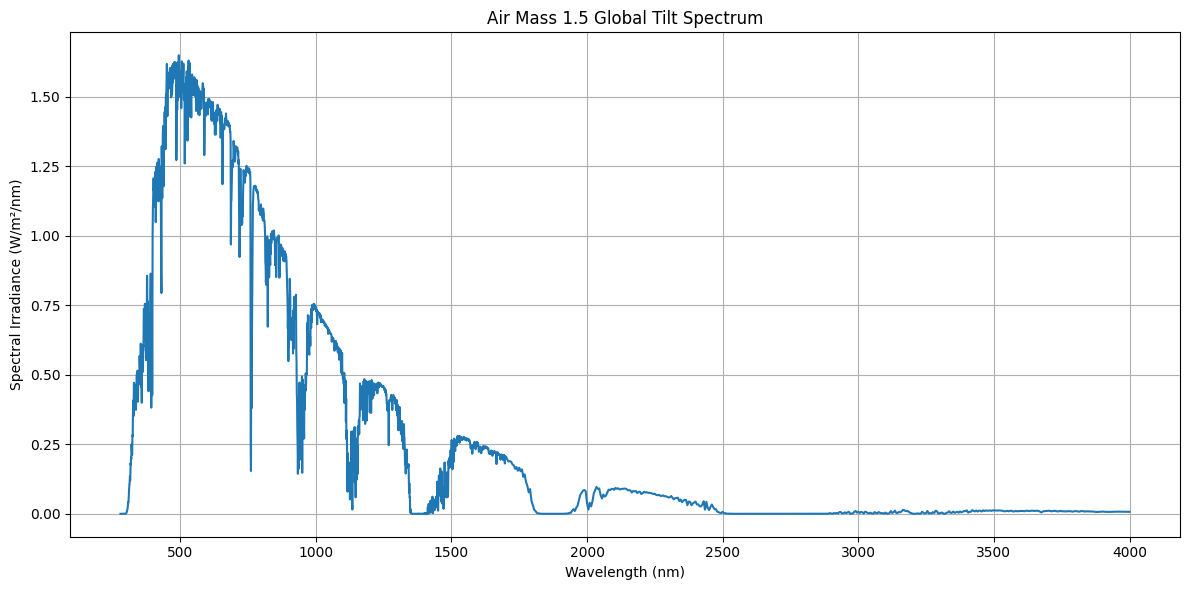

In [ ]:
# Clean column names
data.columns = data.columns.str.strip()

# Convert wavelength to nanometers (if needed)
data['Wvlgth nm'] = pd.to_numeric(data['Wvlgth nm'], errors='coerce')

# Convert irradiance values to numeric, replacing any non-numeric values with NaN
data['Global tilt  W*m-2*nm-1'] = pd.to_numeric(data['Global tilt  W*m-2*nm-1'], errors='coerce')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Wvlgth nm'], data['Global tilt  W*m-2*nm-1'])
#plt.plot(wavelengths_simp2, spectrum_simp2_bc, label='Simplified Spectrum',color='red')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Irradiance (W/m²/nm)')
plt.title('Air Mass 1.5 Global Tilt Spectrum')
plt.grid(True)
plt.tight_layout()
plt.show()

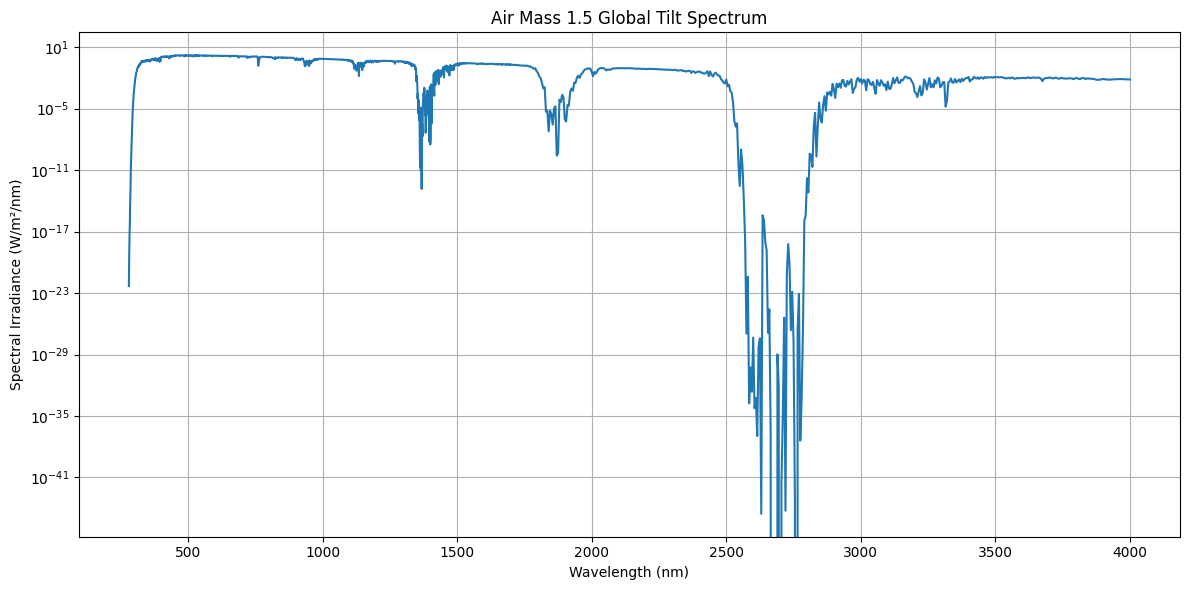

In [ ]:
# Plot the data in log scale
fig =plt.figure(figsize=(12, 6))
ax= fig.add_subplot(111)
ax.plot(data['Wvlgth nm'], data['Global tilt  W*m-2*nm-1'])
#plt.xlabel('Wavelength (nm)')
#plt.ylabel('Spectral Irradiance (W/m²/nm)')
#plt.title('Air Mass 1.5 Global Tilt Spectrum')
#plt.grid(True)
ax.set_yscale('log')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spectral Irradiance (W/m²/nm)')
ax.set_title('Air Mass 1.5 Global Tilt Spectrum')
ax.grid(True)

plt.tight_layout()
plt.show()

the following Central wavelength and elta plus minus come from ST data in their datasheet

In [ ]:
delta_plus_minus = 30
central_wavelength = 940
min_wavelength = 940 - 30
max_wavelength = 940 + 30

delta_wavelength = max_wavelength - min_wavelength

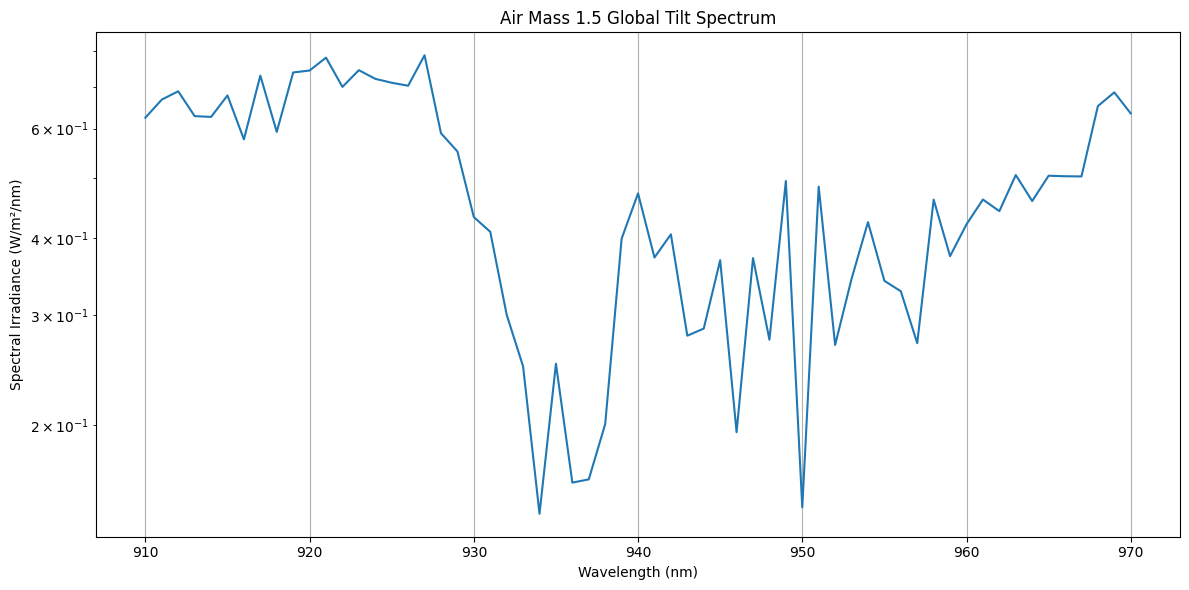

In [ ]:
data_filtered = data[data['Wvlgth nm'].between(min_wavelength, max_wavelength)]
# Plot the data in log scale
fig =plt.figure(figsize=(12, 6))
ax= fig.add_subplot(111)
ax.plot(data_filtered['Wvlgth nm'], data_filtered['Global tilt  W*m-2*nm-1'])
ax.set_yscale('log')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spectral Irradiance (W/m²/nm)')
ax.set_title('Air Mass 1.5 Global Tilt Spectrum')
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
sun_min_max_W_m2_nm = np.array(data_filtered['Global tilt  W*m-2*nm-1'])
print("mean of sun power in the interval",sun_min_max_W_m2_nm.mean(), "W/m2/nm") # W/m2/nm

mean of sun power in the interval 0.47579737704918035 W/m2/nm


In [ ]:
sun_min_max_W_m2= sun_min_max_W_m2_nm.mean() * delta_wavelength
print("sun power in the interval",sun_min_max_W_m2, "W/m2") # W/m2

sun power in the interval 28.54784262295082 W/m2


In [ ]:
Wm2_to_Wmm2 = 1/1000000
print("sun power in the interval",sun_min_max_W_m2*Wm2_to_Wmm2, "W/mm2") # W/mm2

sun power in the interval 2.854784262295082e-05 W/mm2


## parameters for conversions in the lab

W m2 to W mm2 = 1/ 1000000

## parameters for measurement translation with power meter
let's take the characteristics of S120VC
https://www.thorlabs.com/drawings/8ac4e9e207f96a24-4099D5EF-FB84-3144-6F9CAD470C77C347/S120VC-SpecSheet.pdf

input aperture of  the sensor is 9.5 mm
Siz\

In [ ]:
size_of_aperture_m = 9.5e-3 #m
area_of_sensor_m2 = np.pi*(size_of_aperture_m/2)**2
print("sensor area" ,area_of_sensor_m2, "m2") #m2
area_of_sensor_mm2 = area_of_sensor_m2*1000000
print("sensor area" ,area_of_sensor_mm2, "mm2") #m2


sensor area 7.08821842466197e-05 m2
sensor area 70.8821842466197 mm2


In [ ]:
power_sun_W_on_sensor = sun_min_max_W_m2 * area_of_sensor_m2
print(power_sun_W_on_sensor, " W")
print(power_sun_W_on_sensor * 1000, " mW")

0.002023533440643503  W
2.023533440643503  mW


taking as reference the number cited in st datasheet 0.7 W/m2 for an overcast day, we'd have on the surface of the sensor

In [ ]:
sun_min_max_W_m2_ST_data = 0.7 # [W/m2]
power_sun_W_on_sensor_ST_data = sun_min_max_W_m2_ST_data * area_of_sensor_m2
print(power_sun_W_on_sensor_ST_data, " W")
print(power_sun_W_on_sensor_ST_data * 1000, " mW")

4.9617528972633785e-05  W
0.04961752897263379  mW


## parameters for comparison with LED source
let's take some characteristics from M940L3
https://www.thorlabs.com/thorproduct.cfm?partnumber=M940L3

maximum irradiance at 200mm = 19.1 uW/mm2

Led output power = 1000 mW

0.2 low boundary = 875nm

0.2 high boundary =975 nm


In [ ]:
irradiance_LED_at_200mm = 19.1*10**-6 # W/mm2
power_led_W_on_sensor = irradiance_LED_at_200mm * area_of_sensor_mm2
print(power_led_W_on_sensor, " W")

0.0013538497191104362  W


In [ ]:
# Data points as two separate lists
wavelengths = np.array([
    791.1999610621358, 796.045213447605, 800.8906661080456, 805.7359184935148,
    810.5849761034424, 815.4342339883415, 820.2816893984972, 825.1289445336813,
    829.9798046183524, 834.828461678337, 839.6779198382077, 844.5283793729358,
    849.3800405574929, 854.2323025669646, 859.0861667762081, 863.9426345600812,
    868.8009048186977, 873.2574635394822, 877.3084654429815, 880.9570949012428,
    884.2015494395225, 887.0417489478319, 890.0860286520987, 891.9164417541115,
    894.7583435996786, 897.1962908277328, 899.5570120267771, 900.8639263807894,
    903.6250773578482, 905.1348902854859, 907.3711606172409, 909.4112616144129,
    911.4477576620978, 913.0780960675834, 915.032098854508, 916.8247200693991,
    919.7504970730298, 922.0221760197458, 924.1372399387499, 926.8999015613081,
    929.8258502292001, 932.1048992948672, 935.8353010239915, 939.8891868870805,
    943.1322595280569, 945.1683550257989, 950.0128063113821, 953.6367819206519,
    955.8421097693102, 957.6427820380554, 959.237972186043, 960.8316602717442,
    961.6221455842498, 962.4156350213278, 963.0027411002764, 963.7922250379245,
    964.5805073257435, 965.368188788648, 966.1570719013816, 966.7467815549596,
    967.1369171994393, 967.7614546705609, 968.7075736634181, 969.4937530640365,
    970.2811341144837, 971.0682147524739, 972.2635559198641, 972.6532910144007,
    973.4467804514787, 974.2402698885568, 975.0309554760338, 976.6297505735083,
    978.2237390716668, 980.1430141785336, 981.8235815468711, 984.6349414592846,
    987.4488048088419, 991.4743317359669, 996.310371472747, 1001.1530202835867,
    1005.9974715691699, 1010.8421231297245, 1015.686374140336, 1020.5314262508338,
    1025.375476986474, 1030.220328822, 1035.0653809324976, 1037.8916613302881
])

intensities = np.array([
    0.015010384252897913, 0.015420280361231775, 0.016192006584740293, 0.0166019026930746,
    0.023886570989722244, 0.03153306940154432, 0.035923096776796726, 0.039951294036874696,
    0.05049243337009224, 0.05705344143639102, 0.06506176996338753, 0.07487924906625598,
    0.08686770886017103, 0.09994165899960916, 0.11591025006044231, 0.13658263261854287,
    0.16051148621321287, 0.18812700148323191, 0.21248204021725137, 0.2393297012465443,
    0.2654135135345408, 0.2905887450351714, 0.3197461105524355, 0.34418766807414247,
    0.37243845555375543, 0.40032340741876404, 0.4345757682109562, 0.46150874637810746,
    0.48975873275783444, 0.5185390472620902, 0.5467838264925583, 0.5853387612557818,
    0.617380753945866, 0.6450767797544275, 0.6739700493426085, 0.7030788148001221,
    0.7369749531763418, 0.7562467461004277, 0.7843455916349971, 0.8153248108834682,
    0.8495310893584087, 0.8821182305209125, 0.9108120262374808, 0.9403774186300117,
    0.9639646031233049, 0.9952829355830404, 0.994245511230677, 0.976551885082001,
    0.9488939115180243, 0.9196036969363328, 0.883798537531787, 0.8452796522634334,
    0.8145321034724693, 0.7892120064091213, 0.7557487290046343, 0.7231920296377982,
    0.6884643495799158, 0.65265117917651, 0.6190089894641508, 0.590249503556931,
    0.5656490612245018, 0.526867281676894, 0.48551971271109207, 0.44699281644387845,
    0.4106369008677112, 0.3737382401187823, 0.3449847624607074, 0.31966065989792936,
    0.29434056283458143, 0.2690204657712333, 0.23863474709544352, 0.20934252976403722,
    0.17136638966844497, 0.1375183172853851, 0.11007223464125415, 0.0831439295567713,
    0.060738500911968085, 0.039068748995803704, 0.022834459806115426, 0.018540564417182548,
    0.0175031400648189, 0.016827545827629686, 0.015428291360091828, 0.01547635735325148,
    0.01371527277053941, 0.01340150864852463, 0.013449574641684281, 0.013477613137694133
])

In [ ]:
#Print basic information about the arrays
print(f"Number of data points: {len(wavelengths)}")
print(f"Wavelength range: {wavelengths.min():.2f} nm to {wavelengths.max():.2f} nm")
print(f"Peak relative intensity: {intensities.max():.4f} at {wavelengths[np.argmax(intensities)]:.2f} nm")
print(f"Average relative intensity: {intensities.mean():.4f} ")
print(f"Normalization factor")

Number of data points: 88
Wavelength range: 791.20 nm to 1037.89 nm
Peak intensity: 0.9953 at 945.17 nm
Average intensity: 0.3913 
